**Требования:**  
Ответное письмо должно содержать файл с расширением «.py» или «.ipynb» с реализованной функцией или классом на вход которого подается месяц, год и код товара, а возвращается таблица в формате pd.DataFrame.


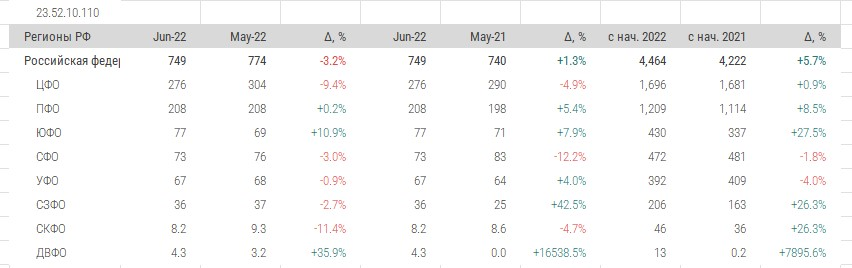

### **Краткое описание особенностей скрипта:**  
а) Скрипт принимает на вход порядковый номер месяца или название месяца в строковом формате в краткой английской аннотации , который преобразует в номер. В случае неправильного спеллинга месяца выдаётся ошибка и скрипт прекращает работу.  
б) В случае отсутствия данных по заданному году скрипт останавливается и выдаёт сообщение.  
в) Функция возвращает таблицу в формате DataFrame, а также выгружает таблицу в формате Styler в Excel, заодно выводит эту таблицу на экран в отформатированном виде.

In [1]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
input_month_ = 5
input_year_ = 2021
input_code_ = '23.52.10.110'

In [3]:
def func_table(input_month, input_year, input_code):
    df = pd.read_csv('Испытательное.csv')
    df['Значение'].fillna(0., inplace = True ) # заменили все NaN нулями

    months = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    month_rev = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    
    if type(input_month) == str:
        input_month = month_rev.get(input_month, 'incorrect month')
        if input_month == 'incorrect month':
            #print(input_month)
            return print('incorrect month spelling')

    # устраняем лишние строки
    df = df.query("Год == @input_year | Год == (@input_year-1)")
    df = df[df['Код ОКПД-2'] == input_code]

    # Функция добавления строк с регионами и остальными колонками со Значением 0 в случае, 
    # если задан начальный год в данных
    def fill_df(df_, code, year):
        df_prel = pd.DataFrame()
        df_prel = df[['Субъект', 'Округ', 'Месяц']].drop_duplicates()
        df_prel['Код ОКПД-2'] = code
        df_prel['Год'] = year-1
        df_prel['Значение'] = 0.0
        return pd.concat([df, df_prel[['Субъект', 'Код ОКПД-2', 'Округ', 'Месяц', 'Год', 'Значение']]], axis = 0)
    
    # Проверка на предмет сравнение с предыдущим годом, которого нет и добавление строк 
    # со Значениями = 0 для корректных расчётов финальноq таблицы + переиндексация строк
    if len(df['Год'].unique()) == 1:
        df = fill_df(df, input_code, input_year)
        df.reset_index(drop = True, inplace = True)
    elif len(df['Год'].unique()) == 0:
        #print('Данные отсутствуют')
        return print('Данные отсутствуют')
    
    df = df.groupby(['Округ', 'Год', 'Месяц'], as_index=False).agg({'Значение':'sum'})

    table = df.query('Месяц == @input_month & Год == @input_year').\
            groupby(['Округ']).agg({'Значение':'sum'}).rename(columns = {'Значение':'input_month'})
    table ['prev_month'] = df.query('Месяц == (@input_month-1) & Год == @input_year').\
            groupby(['Округ']).agg({'Значение':'sum'}).rename(columns = {'Значение':'prev_month'})
    table ['input_month_1'] = df.query('Месяц == @input_month & Год == @input_year').\
            groupby(['Округ']).agg({'Значение':'sum'}).rename(columns = {'Значение':'input_month_1'})
    table ['prev_month_py'] = df.query('Месяц == (@input_month-1) & Год == (@input_year-1)').\
            groupby(['Округ']).agg({'Значение':'sum'}).rename(columns = {'Значение':'prev_month_py'})
    table ['by_input_month'] = df.query('Месяц <=@input_month & Год == @input_year').\
            groupby(['Округ']).agg({'Значение':'sum'}).rename(columns = {'Значение':'by_input_month'})
    table ['by_input_month_py'] = df.query('Месяц <=@input_month & Год == (@input_year-1)').\
            groupby(['Округ']).agg({'Значение':'sum'}).rename(columns = {'Значение':'by_input_month_py'})
    table = pd.concat([table, pd.DataFrame(table.sum(), columns =['Российская Федерация']).T])

    com_1 = lambda x: 1.0 if x['prev_month']==0 else x['input_month']/x['prev_month']-1
    com_2 = lambda x: 1.0 if x['prev_month_py']==0 else x['input_month']/x['prev_month_py']-1
    com_3 = lambda x: 1.0 if x['by_input_month_py']==0 else x['by_input_month']/x['by_input_month_py']-1
    format_pct = lambda x:'{:.1%}'.format(x)

    table['delta_1'] = table.apply(com_1, axis=1)
    table['delta_2'] = table.apply(com_2, axis=1)
    table['delta_3'] = table.apply(com_3, axis=1)
    
    table = table[['input_month','prev_month','delta_1','input_month_1','prev_month_py','delta_2','by_input_month','by_input_month_py','delta_3']]

    table.sort_values('input_month', ascending = False, inplace=True)

    table['delta_1'] = table['delta_1'].apply(format_pct)
    table['delta_2'] = table['delta_2'].apply(format_pct)
    table['delta_3'] = table['delta_3'].apply(format_pct)
    
    table['delta_1'] = table['delta_1'].apply(lambda x: x if '-' in x else '+'+x)
    table['delta_2'] = table['delta_2'].apply(lambda x: x if '-' in x else '+'+x)
    table['delta_3'] = table['delta_3'].apply(lambda x: x if '-' in x else '+'+x)

    table[['input_month', 'prev_month', 'input_month_1','prev_month_py', 'by_input_month', 'by_input_month_py']] =\
    table[['input_month', 'prev_month', 'input_month_1','prev_month_py', 'by_input_month', 'by_input_month_py']].\
    apply(round).astype('int')

    table.reset_index(inplace=True)
    table.rename(columns = {'index':'Регионы РФ',
                          'input_month':months.get(input_month) + '-'+ str(input_year)[2:5],
                          'prev_month':months.get(input_month-1)+ '-'+ str(input_year)[2:5],
                          'input_month_1':months.get(input_month) + '-'+ str(input_year)[2:5],
                          'prev_month_py':months.get(input_month-1)+ '-'+ str(input_year-1)[2:5],
                         'by_input_month':'с начала '+ str(input_year),
                         'by_input_month_py':'с начала '+ str(input_year-1),
                         'delta_1':'\u0394'+', %',
                            'delta_2':'\u0394'+', %',
                            'delta_3':'\u0394'+', %'
                         }, inplace=True)

    def color_negative(v, color):
        if "-" in v:
            return f"color: {color};"
        elif "+" in v:
            return 'color: green'
        else:
            return 'color: None'

    table_ = table.T.reset_index().T.reset_index(drop=True)
    table_.rename(columns={0:input_code}, inplace=True)
    table_st = table_.style.applymap(color_negative, color='red', subset=[3, 6,9])
    #table_st.set_properties(**{'background-color':'lightgrey'},subset=pd.IndexSlice[0])
    table_styles = [{'selector':'table','props':[('border-collapse','collapse'), ('border','none'), 
                    ('text-align','center'),('margin','auto')]},{'selector':'td', 'props':[('border','none')]}]
    table_st.set_table_styles(table_styles).set_properties(**{'background-color':'lightgrey'},subset=pd.IndexSlice[0])
    table_st.to_excel('test.xlsx', header = [input_code,'','','','','','','','',''],index = False)
    display(table_st)
    
    return table

In [4]:
test = func_table(input_month_, input_year_, input_code_)

,23.52.10.110,1,2,3,4,5,6,7,8,9
0,Регионы РФ,May-21,Apr-21,"Δ, %",May-21,Apr-20,"Δ, %",с начала 2021,с начала 2020,"Δ, %"
1,Российская Федерация,720,703,+2.4%,720,721,-0.1%,3481,3557,-2.1%
2,ЦФО,296,276,+7.1%,296,278,+6.3%,1391,1348,+3.2%
3,ПФО,186,181,+2.7%,186,181,+2.3%,917,935,-2.0%
4,СФО,82,83,-1.6%,82,79,+3.7%,398,394,+1.0%
5,УФО,71,71,+0.6%,71,80,-11.7%,344,402,-14.3%
6,ЮФО,52,59,-12.9%,52,49,+5.6%,266,238,+11.5%
7,СЗФО,27,27,+1.7%,27,48,-43.0%,138,218,-36.7%
8,СКФО,7,6,+12.4%,7,6,+27.2%,28,23,+22.1%
9,ДВФО,0,0,+15.4%,0,0,+100.0%,0,0,-62.6%


In [5]:
test.head()

,Регионы РФ,May-21,Apr-21,"Δ, %",May-21,Apr-20,"Δ, %",с начала 2021,с начала 2020,"Δ, %"
0,Российская Федерация,720,703,+2.4%,720,721,-0.1%,3481,3557,-2.1%
1,ЦФО,296,276,+7.1%,296,278,+6.3%,1391,1348,+3.2%
2,ПФО,186,181,+2.7%,186,181,+2.3%,917,935,-2.0%
3,СФО,82,83,-1.6%,82,79,+3.7%,398,394,+1.0%
4,УФО,71,71,+0.6%,71,80,-11.7%,344,402,-14.3%
